In [ ]:
# import gdown
# hrf_dir = "https://drive.google.com/drive/folders/1xJDfTYSojpIKtAUl8lMcNXzgac9jq620?usp=drive_link"
# gdown.download_folder(hrf_dir, quiet=True)

# Shared Module

## Dataset

In [23]:
import os
import glob
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF

class HRF_Dataset(Dataset):
    def __init__(self, root_folder):
        self.root_folder = root_folder

        self.images = sorted(
            glob.glob(os.path.join(self.root_folder, 'images', '**.jpg')) +
            glob.glob(os.path.join(self.root_folder, 'images', '**.JPG'))
        )
        self.masks = sorted(
            glob.glob(os.path.join(root_folder, 'manual1', '**.tif'))
        )

        assert len(self.images) == len(self.masks), "Number of mask and image mis-match!"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        # Đọc ảnh RGB bằng OpenCV (BGR -> RGB)
        image = cv2.imread(self.images[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Đọc mask ảnh xám
        mask = cv2.imread(self.masks[index], cv2.IMREAD_GRAYSCALE)

        # Chuyển về tensor [0,1]
        image = TF.to_tensor(image)  # Tự động scale về [0,1]
        mask = TF.to_tensor(mask)    # Cho ảnh xám, vẫn ra [1,H,W]

        return {
            "image": image,
            "mask": mask
        }


## Compute score

In [24]:
import torch
import numpy as np

def compute_dice(predicted_mask, mask, threshold=0.5):
    iou = compute_iou(predicted_mask, mask)
    return 2 * iou / (1 + iou) if iou != 0 else torch.tensor(0.0)


def compute_iou(pred_mask, true_mask):
    intersection = np.logical_and(pred_mask, true_mask).sum()
    union = np.logical_or(pred_mask, true_mask).sum()
    iou = intersection / union if union != 0 else 0
    return iou


def compute_scores(predicted_masks: list, masks: list) -> dict:
    metrics = {
        "iou": compute_iou,
        "dice": compute_dice
    }
    scores = {metric_name: [] for metric_name in metrics}

    for predicted_mask, mask in zip(predicted_masks, masks):
        for metric_name, scorer in metrics.items():
            scores[metric_name].append(scorer(predicted_mask, mask))

    return {metric_name: np.mean(values) for metric_name, values in scores.items()}



## Loss function

In [25]:
def dice_loss(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum(dim=(2,3))
    union = pred.sum(dim=(2,3)) + target.sum(dim=(2,3))
    dice = (2. * intersection + smooth) / (union + smooth)

    return 1 - dice.mean()

## Utils

In [26]:
import random

def set_seed(seed=33):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## Helper Function

In [27]:
import torch 

def compute_partial(M):
    """
    M2: tensor có shape (B, C, H, W)
    Trả về: tensor shape (B, 1, 1, 1) chứa giá trị ∂ cho từng batch
    """
    B, C, H, W = M.shape
    device = M.device

    # Tạo chỉ số i, j theo không gian H, W
    i = torch.arange(H, device=device).view(H, 1).expand(H, W) + 1
    j = torch.arange(W, device=device).view(1, W).expand(H, W) + 1

    # Tính ma trận i * j
    ij = (i * j).unsqueeze(0).unsqueeze(0)  # shape: (1, 1, H, W)

    # Áp dụng công thức tổng
    weighted = M / ij  # chia từng pixel cho i * j
    partial = weighted.view(B, C, -1).sum(dim=2).view(B, C, 1, 1)  # tổng theo từng ảnh

    return partial


def compute_eqs2(Light):
    """
    Light: tensor shape (B, C, H, W)
    Output: Eqs2, shape (B, C, 1, 1)
    """
    B, C, H, W = Light.shape
    device = Light.device

    # Tạo chỉ số i và j
    i_idx = torch.arange(H, device=device).view(H, 1).expand(H, W)
    j_idx = torch.arange(W, device=device).view(1, W).expand(H, W)

    # Tính index theo công thức: i * n + j
    pos = (i_idx * W + j_idx).float() + 1e-6  # tránh chia cho 0
    # pos = pos.view(1, 1, H, W)  # reshape để broadcast với Light

    # Tính giá trị Eqs2(I)
    weighted = Light / pos        # shape (B, C, H, W)
    eqs2 = weighted.sum(dim=(2, 3)) 
    eqs2 = eqs2.view(B, C, 1, 1)  
    return eqs2


# TAOD-CFNET

## ODGA

In [28]:
import torch.nn as nn
class ODGA(nn.Module):
    def __init__(self):
        super(ODGA, self).__init__()

    def forward(self, x):
        """
        x: tensor đầu vào shape (B, 3, H, W) - ảnh RGB (3 kênh giống nhau).
        Output: tensor sau khi điều chỉnh độ sáng vùng đĩa thị.
        """
        B, C, H, W = x.shape
        # assert C == 3, "ODGA yeu cau 3 kenh mau gray-scale"
        if C == 3:
            I = x[:, 0:1, :, :].clone()  # shape (B, 1, H, W)
        else: 
            I = x 
            
        MaxI = torch.amax(I, dim=(2, 3), keepdim=True)
        MinI = torch.amin(I, dim=(2, 3), keepdim=True)

        Eqs1 = MaxI / 2

        Bound = (3/4) * (1 - (MinI/MaxI))
        Step = (7/8) * (1 - (MinI/MaxI))

        I = torch.where(I > Eqs1, I * Step, I)

        Eqs2 = compute_eqs2(I)

        odga = torch.where(I > Eqs2, I * Bound, I)  # shape: (B, 1, H, W)
        odga = odga.repeat(1, 3, 1, 1)  # shape: (B, 3, H, W)
        return odga


## Helper Function

In [29]:
def compute_partial(M):
    """
    M2: tensor có shape (B, C, H, W)
    Trả về: tensor shape (B, 1, 1, 1) chứa giá trị ∂ cho từng batch
    """
    B, C, H, W = M.shape
    device = M.device

    # Tạo chỉ số i, j theo không gian H, W
    i = torch.arange(H, device=device).view(H, 1).expand(H, W) + 1
    j = torch.arange(W, device=device).view(1, W).expand(H, W) + 1

    # Tính ma trận i * j
    ij = (i * j).unsqueeze(0).unsqueeze(0)  # shape: (1, 1, H, W)

    # Áp dụng công thức tổng
    weighted = M / ij  # chia từng pixel cho i * j
    partial = weighted.view(B, C, -1).sum(dim=2).view(B, C, 1, 1)  # tổng theo từng ảnh

    return partial


def compute_eqs2(Light):
    """
    Light: tensor shape (B, C, H, W)
    Output: Eqs2, shape (B, C, 1, 1)
    """
    B, C, H, W = Light.shape
    device = Light.device

    # Tạo chỉ số i và j
    i_idx = torch.arange(H, device=device).view(H, 1).expand(H, W)
    j_idx = torch.arange(W, device=device).view(1, W).expand(H, W)

    # Tính index theo công thức: i * n + j
    pos = (i_idx * W + j_idx).float() + 1e-6  # tránh chia cho 0
    # pos = pos.view(1, 1, H, W)  # reshape để broadcast với Light

    # Tính giá trị Eqs2(I)
    weighted = Light / pos        # shape (B, C, H, W)
    eqs2 = weighted.sum(dim=(2, 3))
    eqs2 = eqs2.view(B, C, 1, 1)
    return eqs2


## CFB

In [30]:
class VGGBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(VGGBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels // 2, kernel_size=3, padding=1),  # giữ nguyên kích thước
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels // 2, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.main = VGGBlock(in_channels, out_channels)
        self.shortcut = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.main(x) + self.shortcut(x)

class CFB(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CFB, self).__init__()
        self.vgg_block = VGGBlock(in_channels, out_channels)
        self.res_block = ResidualBlock(in_channels, out_channels)
        self.omega = 0.5

    def forward(self, x):
        B, C_in, H, W = x.shape

        # Branch 1 - VGG
        V = self.vgg_block(x)

        # Branch 2 - Residual
        R = self.res_block(x)

        # Initial fusion
        C = (V + R) / 2

        # Activation
        M1 = self.omega * (torch.sigmoid(V) + torch.relu(R))
        M2 = torch.relu(R)

        # Compute ∂ (partial)
        partial = compute_partial(M2)  # shape (B, C, 1, 1)

        # M3 - remove low-activated values
        M3 = torch.where(M1 > partial, M1, torch.zeros_like(M1))

        # β calculation
        maxM1 = torch.amax(M1, dim=(2, 3))                # shape (B, C)
        minM1 = torch.amin(M1, dim=(2, 3))                # shape (B, C)
        partial_M1 = compute_partial(M1).squeeze(-1).squeeze(-1)  # shape (B, C)

        beta = (maxM1 + partial_M1) / (partial_M1 - minM1 + 1e-6)  # shape (B, C)
        beta = beta.unsqueeze(-1).unsqueeze(-1)  # (B, C, 1, 1)

        # Final output
        out = torch.where(M1 > partial, beta * M3 * C * M2, M3 * C * M2)
        return out


## Trumpet Attention

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.double_conv(x)

class TrumpetAttention(nn.Module):
    def __init__(self, in_channels, threshold=0.9, coef=0.1):
        super(TrumpetAttention, self).__init__()
        # Tạo instance riêng biệt cho từng nhánh
        self.doubleconv_horizontal = DoubleConv(in_channels, in_channels)
        self.doubleconv_vertical = DoubleConv(in_channels, in_channels)

        # Các lớp convolution cho nhánh horizontal, vertical và fusion
        self.conv_horizon = nn.Conv2d(in_channels*2, in_channels, kernel_size=3, padding=1)
        self.conv_vertical = nn.Conv2d(in_channels*2, in_channels, kernel_size=3, padding=1)
        self.conv_fusion = nn.Conv2d(in_channels*2, in_channels, kernel_size=3, padding=1)

        self.threshold = threshold
        self.coef = coef

    def forward(self, x):  # x: (B, C, H, W)
        B, C, H, W = x.shape

        # Nhánh Horizontal:
        x_horizon0 = x.permute(0, 3, 2, 1)  # (B, W, H, C)
        # Tạo ra attention đầu tiên (sử dụng sigmoid và relu)
        x_horizon_1 = torch.sigmoid(torch.sigmoid(x_horizon0) +
                                     torch.relu(x.permute(0, 3, 1, 2)).permute(0, 1, 3, 2))
        x_horizon_2 = x_horizon_1.permute(0, 3, 2, 1)  # (B, C, H, W)
        # Dùng double conv riêng cho nhánh horizontal
        x_horizon_21 = self.doubleconv_horizontal(x_horizon_2)
        # Nối kết quả với đầu vào gốc đã được sigmoid
        x_horizon_3 = torch.cat([torch.sigmoid(x), x_horizon_21], dim=1)
        x_horizon_4 = self.conv_horizon(torch.sigmoid(x_horizon_3))

        # Nhánh Vertical:
        x_vertical0 = x.permute(0, 3, 1, 2)  # (B, W, C, H)
        x_vertical_1 = torch.relu(torch.relu(x_vertical0) +
                                  torch.sigmoid(x.permute(0, 3, 2, 1)).permute(0, 1, 3, 2))
        x_vertical_2 = x_vertical_1.permute(0, 2, 1, 3)  # (B, C, W, H)
        # Dùng double conv riêng cho nhánh vertical
        x_vertical_21 = self.doubleconv_vertical(x_vertical_2)
        x_vertical_3 = torch.cat([torch.relu(x), x_vertical_21], dim=1)
        x_vertical_4 = self.conv_vertical(torch.relu(x_vertical_3))

        # Kết hợp 2 nhánh:
        x_combined = torch.cat([x_vertical_4, x_horizon_4], dim=1)  # (B, 2C, H, W)
        x_combined = self.conv_fusion(torch.sigmoid(x_combined))    # (B, C, H, W)

        # Giai đoạn cuối: thresholding và residual connection
        x_combined = torch.where(x_combined < self.threshold, 
                                 torch.zeros_like(x_combined), 
                                 x_combined * self.coef)
        out = x + x_combined
        return out


## TAOD-CFNet Model

In [32]:
import torch.nn.functional as F

class TAOD_CFNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TAOD_CFNet, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.odga = ODGA()

        # Encoder
        self.cfb0_0 = CFB(self.in_channels, 64)
        self.tam1 = TrumpetAttention(64)
        self.maxpool0 = nn.MaxPool2d(kernel_size=2)

        self.cfb0_1 = CFB(64, 128)
        self.tam2 = TrumpetAttention(128)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.cfb0_2 = CFB(128, 256)
        self.tam3 = TrumpetAttention(256)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)

        self.cfb0_3 = CFB(256, 512)
        self.tam4 = TrumpetAttention(512)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)

        self.cfb0_4 = CFB(512, 1024)
        self.cfb0_5 = CFB(1024, 1024)

        # Decoder: Cat the TAM before conduct the CFB
        self.cfb1_0 = CFB(1024, 1024)
        self.up1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(1024, 512, kernel_size=1)
        )

        self.cfb1_1 = CFB(1024, 512)
        self.up2 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(512, 256, kernel_size=1)
        )

        self.cfb1_1 = CFB(1024, 512)
        self.up2 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(512, 256, kernel_size=1)
        )

        self.cfb1_2 = CFB(512, 256)
        self.up3 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(256, 128, kernel_size=1)
        )

        self.cfb1_3 = CFB(256, 128)
        self.up4 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(128, 64, kernel_size=1)
        )

        self.cfb1_4 = CFB(128, 64)
        self.out_conv = nn.Conv2d(64, self.out_channels, kernel_size=1)



    def forward(self, x):
        x = self.odga(x)

        # ======== Encoder ========
        x0 = self.cfb0_0(x)  # 64
        t0 = self.tam1(x0)
        x1 = self.maxpool0(t0)

        x1 = self.cfb0_1(x1)  # 128
        t1 = self.tam2(x1)
        x2 = self.maxpool1(t1)

        x2 = self.cfb0_2(x2)  # 256
        t2 = self.tam3(x2)
        x3 = self.maxpool3(t2)

        x3 = self.cfb0_3(x3)  # 512
        t3 = self.tam4(x3)
        x4 = self.maxpool4(t3)

        x4 = self.cfb0_4(x4)  # bottleneck 1024
        x5 = self.cfb0_5(x4)

        # ======== Decoder ========
        d0 = self.cfb1_0(x5)   # 1024
        up1 = self.up1(d0)     # upsample to 512
        d1 = self.cfb1_1(torch.cat([up1, t3], dim=1))  # concat với TAM từ encoder

        up2 = self.up2(d1)     # 256
        d2 = self.cfb1_2(torch.cat([up2, t2], dim=1))

        up3 = self.up3(d2)     # 128
        d3 = self.cfb1_3(torch.cat([up3, t1], dim=1))

        up4 = self.up4(d3)     # 64
        d4 = self.cfb1_4(torch.cat([up4, t0], dim=1))

        out = self.out_conv(d4)
        return torch.sigmoid(out)


# Model information 

In [34]:
from torchinfo import summary 
summary(TAOD_CFNet(3, 1), input_data=torch.rand(3, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
TAOD_CFNet                               [3, 1, 32, 32]            --
├─ODGA: 1-1                              [3, 3, 32, 32]            --
├─CFB: 1-2                               [3, 64, 32, 32]           --
│    └─VGGBlock: 2-1                     [3, 64, 32, 32]           --
│    │    └─Sequential: 3-1              [3, 64, 32, 32]           19,392
│    └─ResidualBlock: 2-2                [3, 64, 32, 32]           --
│    │    └─VGGBlock: 3-2                [3, 64, 32, 32]           19,392
│    │    └─Sequential: 3-3              [3, 64, 32, 32]           256
├─TrumpetAttention: 1-3                  [3, 64, 32, 32]           --
│    └─DoubleConv: 2-3                   [3, 64, 32, 32]           --
│    │    └─Sequential: 3-4              [3, 64, 32, 32]           74,112
│    └─Conv2d: 2-4                       [3, 64, 32, 32]           73,792
│    └─DoubleConv: 2-5                   [3, 64, 32, 32]           -

# Main

In [ ]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

from tqdm import tqdm
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from shutil import copyfile

import os
import torch.nn as nn

def train_model(epoch: int, model: nn.Module, dataloader: DataLoader, optim: torch.optim.Optimizer, device: torch.device):
    model.train()
    running_loss = .0
    with tqdm(desc=f'Epoch {epoch} - Training', unit='it', total=len(dataloader)) as pb:
        for it, batch in enumerate(dataloader):
            image = batch['image'].to(device)
            mask = batch['mask'].to(device)

            masked = model(image)
            loss = dice_loss(masked, mask)

            # Back propagation
            optim.zero_grad()
            loss.backward()
            optim.step()
            running_loss += loss.item()

            # Update training status
            pb.set_postfix(loss=running_loss / (it + 1))
            pb.update()

    return running_loss / len(dataloader)

def evaluate_model(epoch: int, model: nn.Module, dataloader: DataLoader, device: torch.device) -> dict:
    model.eval()
    all_predictions = []
    all_masks = []

    with tqdm(desc=f'Epoch {epoch} - Evaluating', unit='it', total=len(dataloader)) as pb:
        for batch in dataloader:
            image = batch['image'].to(device)
            mask = batch['mask'].to(device)

            with torch.no_grad():
                logits = model(image)

            probs = torch.sigmoid(logits)
            prediction = (probs > 0.5).long().cpu().numpy()
            mask = mask.cpu().numpy()

            all_predictions.extend(prediction)
            all_masks.extend(mask)

            pb.update()

    scores = compute_scores(all_predictions, all_masks)
    return scores

def save_checkpoint(dict_to_save: dict, checkpoint_dir: str):
    os.makedirs(checkpoint_dir, exist_ok=True)
    torch.save(dict_to_save, os.path.join(checkpoint_dir, "last_model.pth"))



def main(folder_dir, checkpoint_dir):
    set_seed(33)

    # Load data
    data = HRF_Dataset(folder_dir)
    train_indices, val_indices = train_test_split(range(len(data)), test_size=0.3, random_state=42)

    train_dataset = torch.utils.data.Subset(data, train_indices)
    val_dataset = torch.utils.data.Subset(data, val_indices)

    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
    eval_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Define model
    model = TAOD_CFNet(3, 1)
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=2e-3)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5)


    epoch = 0
    allowed_patience = 5
    best_score = 0
    compared_score = "dice"
    patience = 0
    exit_train = False

    # Training model
    while not exit_train :
        train_loss = train_model(epoch, model, train_loader, optimizer, device)
        scores = evaluate_model(epoch, model, eval_loader, device)
        print(f"Epoch {epoch}: IOU = {scores['iou']}, Dice = {scores['dice']}, Train Loss = {train_loss:.4f}")

        score = scores[compared_score]
        scheduler.step(score)  # Cập nhật learning rate dựa trên Dice Score

        is_best_model = False
        if score > best_score:
            best_score = score
            patience = 0
            is_best_model = True
        else:
            patience += 1

        if patience == allowed_patience or epoch == 30:
            exit_train = True

        save_checkpoint({
            "epoch": epoch,
            "best_score": best_score,
            "patience": patience,
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict()
        }, checkpoint_dir)

        if is_best_model:
            copyfile(
                os.path.join(checkpoint_dir, "last_model.pth"),
                os.path.join(checkpoint_dir, "best_model.pth")
            )

        epoch += 1

if __name__ == "__main__":
    main(
        folder_dir='/content/drive/MyDrive/Colab Notebooks/Research Experiment/Dataset/hrf',
        checkpoint_dir='/content/checkpoint'
    )

Epoch 0 - Evaluating: 100%|██████████| 14/14 [00:21<00:00,  1.53s/it]


Epoch 0: IOU = 0.07699693952287946, Dice = 0.1426445959275001, Train Loss = 0.8629


Epoch 1 - Evaluating: 100%|██████████| 14/14 [00:06<00:00,  2.11it/s]


Epoch 1: IOU = 0.07699693952287946, Dice = 0.1426445959275001, Train Loss = 0.8619


Epoch 2 - Evaluating: 100%|██████████| 14/14 [00:07<00:00,  1.94it/s]


Epoch 2: IOU = 0.07699693952287946, Dice = 0.1426445959275001, Train Loss = 0.8632


Epoch 3 - Evaluating: 100%|██████████| 14/14 [00:07<00:00,  1.86it/s]


Epoch 3: IOU = 0.07699693952287946, Dice = 0.1426445959275001, Train Loss = 0.8632


Epoch 4 - Evaluating: 100%|██████████| 14/14 [00:06<00:00,  2.10it/s]


Epoch 4: IOU = 0.07699693952287946, Dice = 0.1426445959275001, Train Loss = 0.8631


Epoch 5 - Evaluating: 100%|██████████| 14/14 [00:06<00:00,  2.04it/s]


Epoch 5: IOU = 0.07699693952287946, Dice = 0.1426445959275001, Train Loss = 0.8622


# Inference

In [ ]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

def load_model(checkpoint_dir: str, device: torch.device, model=TAOD_CFNet(3, 1)) -> torch.nn.Module:

    # Changed checkpoint_dir to checkpoint_path with the file name.
    checkpoint_path = os.path.join(checkpoint_dir, "last_model.pth")
    checkpoint = torch.load(checkpoint_path, weights_only=False)
    model.load_state_dict(checkpoint["state_dict"])
    model.to(device)
    model.eval()
    print("Model has been loaded successfully!")

    return model


def inference(image: torch.Tensor, mask: torch.Tensor, model: torch.nn.Module, device: torch.device):
    image = image.to(device)
    mask = mask.to(device)

    image = image.unsqueeze(0)

    with torch.no_grad():
        logits = model(image)
        pred = torch.sigmoid(logits)
        pred = (pred > 0.5).float().cpu().numpy().squeeze()

    image = image.squeeze(0).cpu().permute(1, 2, 0).numpy() # Convert from (C, H, W) to (H, W, C)
    image = (image * 0.5) + 0.5 # Revert Normalize

    mask = mask.cpu().numpy().squeeze()

    return image, mask, pred



def plot_results(image, mask, pred):

    plt.figure(figsize=(15, 5))

    # Original image
    plt.subplot(1, 3, 1)
    plt.title("Original image")
    plt.imshow(image)
    plt.axis("off")

    # True mask
    plt.subplot(1, 3, 2)
    plt.title("True mask")
    plt.imshow(mask)
    plt.axis("off")

    # Prediction mask
    plt.subplot(1, 3, 3)
    plt.title("Prediction mask")
    plt.imshow(pred)

    plt.show()

    # Calculating score for each tuple of results
    print(f"Dice Score: {compute_dice(pred, mask)}")
    print(f"IOU Scores: {compute_iou(pred, mask)}")



In [ ]:
checkpoint_dir = "/content/checkpoint"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
model = TAOD_CFNet(3, 1)
model = load_model(checkpoint_dir, device, model)


Model has been loaded successfully!


In [ ]:
dataset = HRF_Dataset(root_folder="/content/drive/MyDrive/Colab Notebooks/Research Experiment/Dataset/hrf")

random_indices = random.sample(range(len(dataset)), 10)
random_samples = [dataset[i] for i in random_indices]

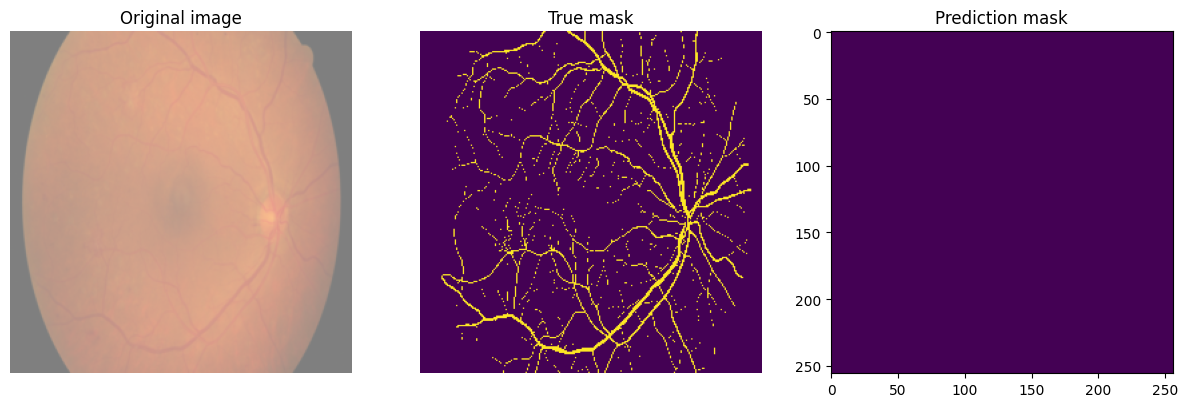

Dice Score: 0.12887937187723056
IOU Scores: 0.068878173828125


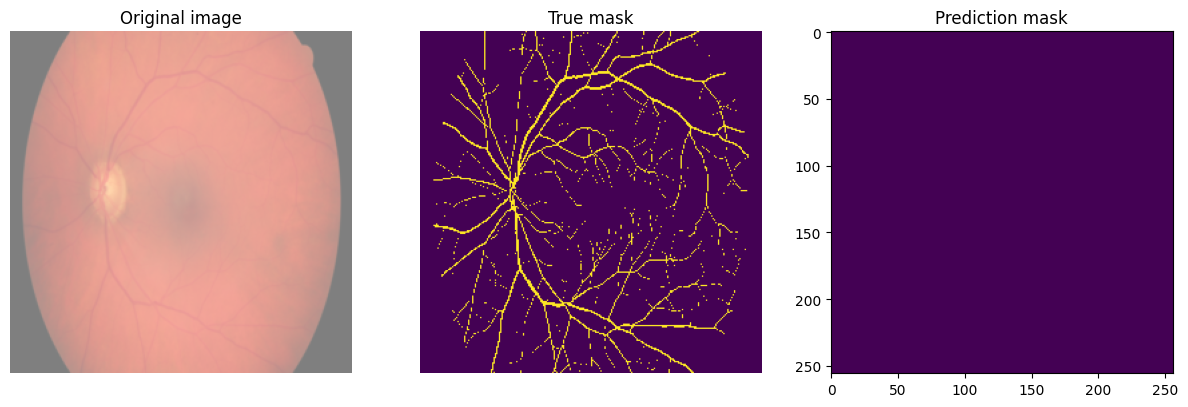

Dice Score: 0.120292557005593
IOU Scores: 0.063995361328125


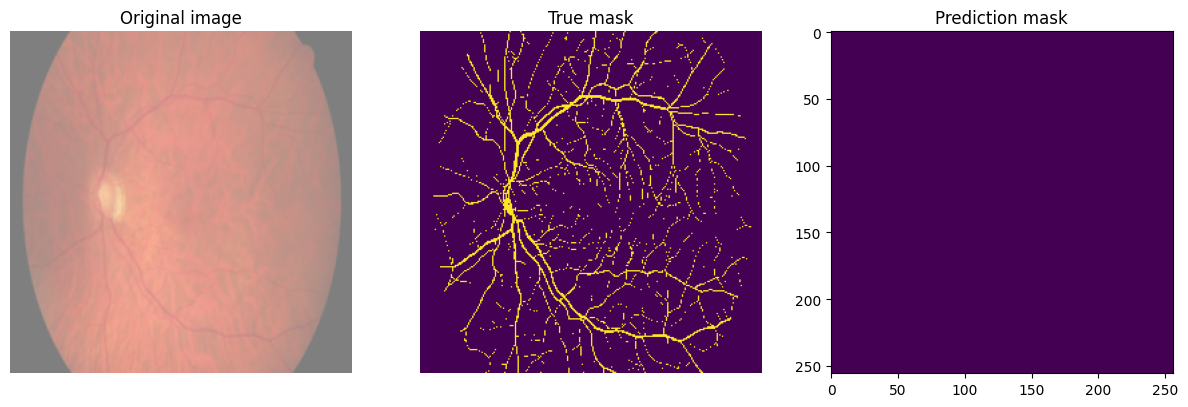

Dice Score: 0.1330370623593425
IOU Scores: 0.071258544921875


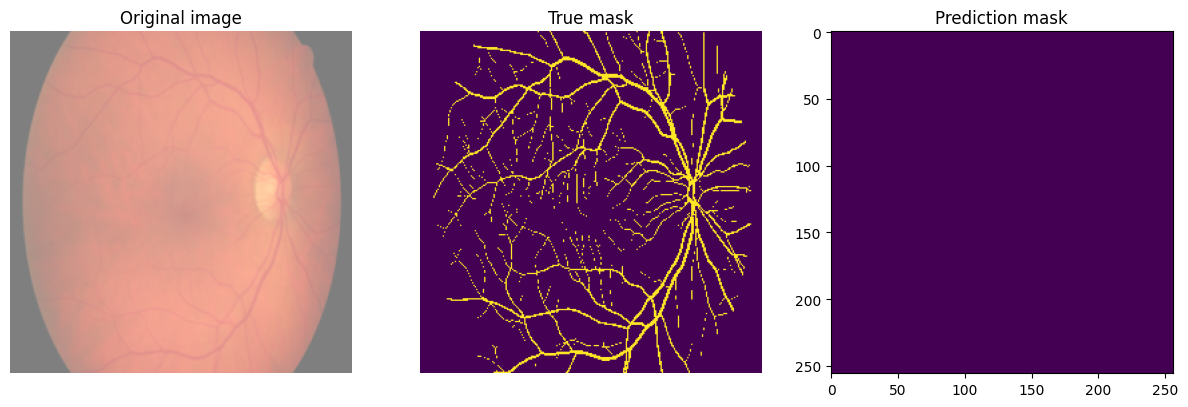

Dice Score: 0.165311235844963
IOU Scores: 0.0901031494140625


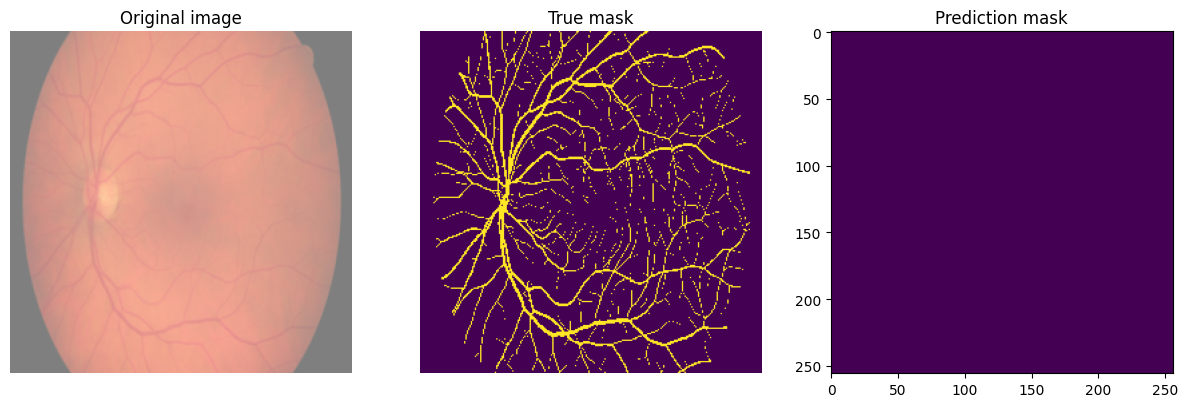

Dice Score: 0.18469890864772034
IOU Scores: 0.10174560546875


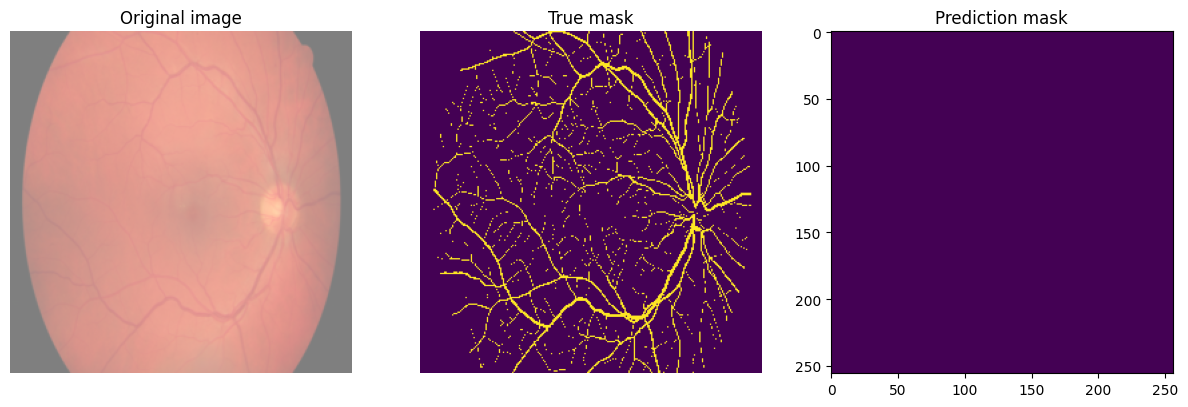

Dice Score: 0.15674527837545177
IOU Scores: 0.0850372314453125


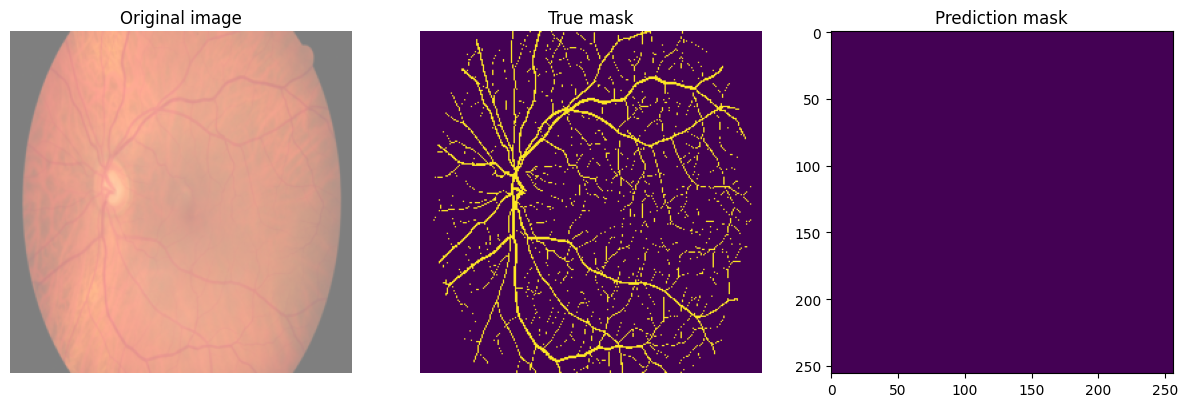

Dice Score: 0.1529529473105703
IOU Scores: 0.0828094482421875


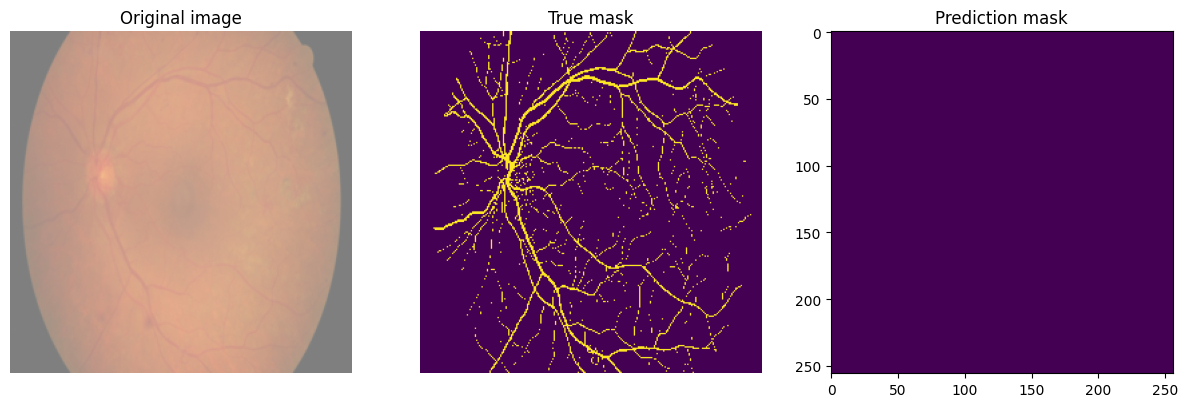

Dice Score: 0.12751610737296248
IOU Scores: 0.0680999755859375


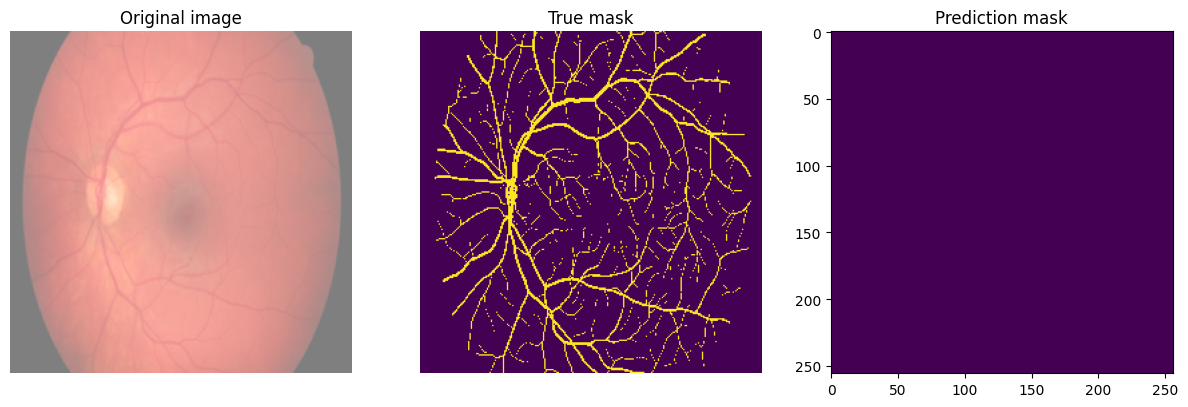

Dice Score: 0.17395059836442414
IOU Scores: 0.0952606201171875


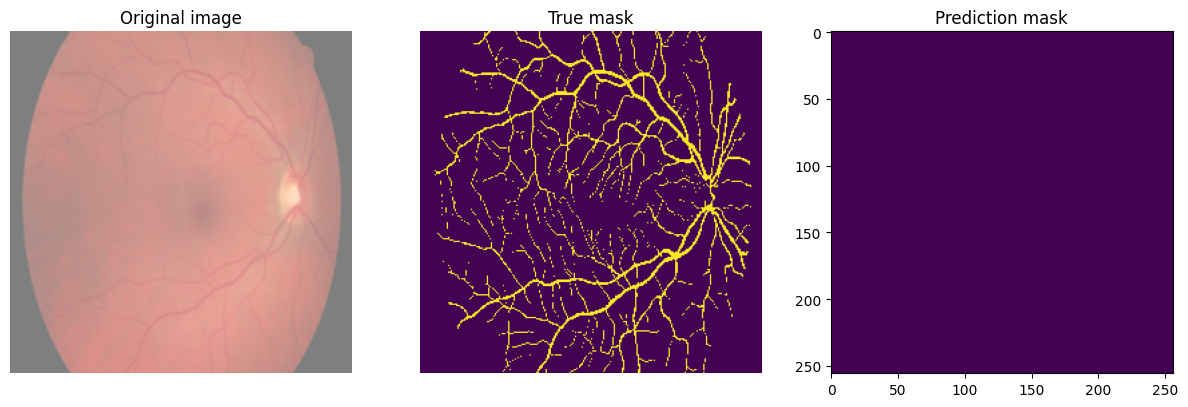

Dice Score: 0.1700244328097731
IOU Scores: 0.0929107666015625


In [ ]:
for tuple in random_samples:
    image = tuple['image']
    mask = tuple['mask']

    image, mask, pred = inference(image, mask, model, device)
    plot_results(image, mask, pred)
